In [ ]:
from wtlike import *
import numpy as np

# wtlike tutorial

> A step by step guide

### Install `wtlike`

This assumes that you already have a Jupyter Notebook Server configured on your machine. 

Either run this [notebook](https://github.com/tburnett/wtlike/blob/master/nbs/99_tutorial.ipynb), or copy the cells into a new notebook.

`wtlike` is on PyPI

```
pip install wtlike

```
We use a simulated on-the-fly dataset in lieu of downloading the 2-GB file with all of *fermi* data.

### Define a source flux function. 
Note that we measure time in day units, and will pick a 30-day interval for this demo.

The following function has a flare at 15 days.

In [ ]:
def src_flare(t, tzero=15, width=1, amp=5):
    return 1e-6*(1 + amp*np.exp(-(t-tzero)**2/2/width))

We use it to tell the simulation that the flux has this behavior. Note defaults:

- background -- 1e-6 /s
- effective area -- 3000 cm^2 

Here we create a `Simulation` object, then pass it to the primary wtlike entry point, the class `WtLike`.
We tell it to immediately bin the photons into daily time-bins, called "cells". (That can be easily redone.)

In [ ]:
config=Config(cachepath=None, datapath=None)
test_sim = Simulation('flare_sim', src_flux=src_flare, tstart=0, tstop=30, )
daily = WtLike(test_sim, config=config, time_bins=(0,0,1))

generated 18803 photons
SourceData: Source flare_sim with:
	 data:        18,803 simulated photons over 30.0 days.
	 exposure:     8,640 intervals,  average flux 3000 cm^2 for 2.6 Ms
	 rates:  source 1.42e-06/s, background 1.00e-06/s, S/N ratio 1.42e+00
CellData: Bin photon data into 30 1-day bins from 0.0 to 30.0
LightCurve: select 30 cells for fitting with e>5 & n>2


Now make a light curve!

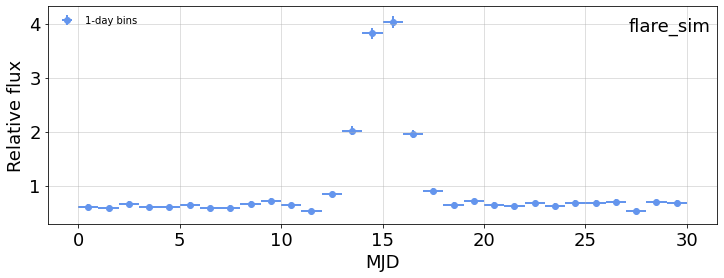

In [ ]:
daily.plot();

The cells have each been analyzed to create a likelihood function representation. The first few cells are:

In [ ]:
daily.cells.head(2)

,t,tw,e,n,w,S,B
0,0.5,1.0,258.3,513,"[0.72159, 0.8187301, 0.0013817119, 0.8750448, ...",366.09,258.5
1,1.5,1.0,259.2,502,"[0.0040837848, 0.7154309, 0.60679317, 0.394869...",367.36,259.4


The Kerr likelihood function for a cell is a function of $w$, the list of weights, and $S$, an estimate for the total signal counts in the cell

$$ \displaystyle\log\mathcal{L}(\alpha\ |\ w)\ = \sum_{w}  \log \big( 1 + \alpha\ w \big) - \alpha\ S  $$

where $\alpha$ is the variation from the nominal zero. The background is assumed to be constant here, as it usually is the region surrounding sources of interest. 
The relative flux is $1+\alpha$. 

We generate an approximate representation of this function by fitting it to a 3-parameter Poisson-like function, which easily provides the values of interest.

In [ ]:
daily.fluxes.head(2)

,t,tw,n,e,ts,flux,errors,limit
0,0.5,1.0,513,258.3,359.6,0.60,"(-0.048, 0.049)",0.69
1,1.5,1.0,502,259.2,338.2,0.58,"(-0.047, 0.049)",0.66


Note that the properties `photons`, `exposure`, `cells`, `fits`, and `fluxes` are [DataFrames](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html). So we can find a fit at the peak with a `query`.

In [ ]:
daily.fluxes.query('flux>3')

,t,tw,n,e,ts,flux,errors,limit
14,14.5,1.0,1549,259.2,9302.3,3.82,"(-0.103, 0.105)",4.00
15,15.5,1.0,1642,259.2,9922.0,4.03,"(-0.106, 0.108)",4.21


## Views
A `WtLike` object provides a function `view`, which returns a **new** instance with a different binning. 
So if we want a detailed look at the flare, we can choose an interval. The parameters specify

CellData: Bin photon data into 40 6-hour bins from 10.0 to 20.0
LightCurve: select 40 cells for fitting with e>5 & n>2


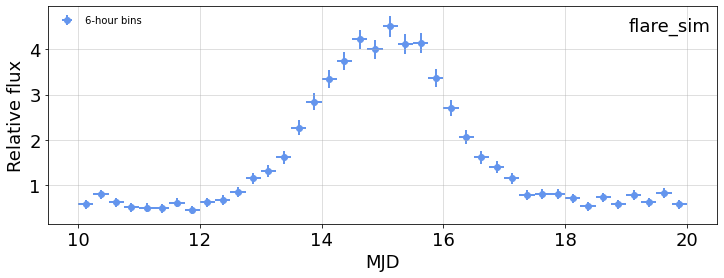

In [ ]:
qday = daily.view(10, -10, 0.25)
qday.plot();

### Bayesian-Block view
The WtLike object also has a special `bb_view` function, which does a Bayesian Block analysis and returns a view of it. 

LightCurve: select 40 cells for fitting with e>5 & n>2
Bayesian Blocks: using penalty 0.05
	Partitioned 40 cells into 9 blocks, using LikelihoodFitness 
LightCurve: Loaded 9 / 9 cells for fitting


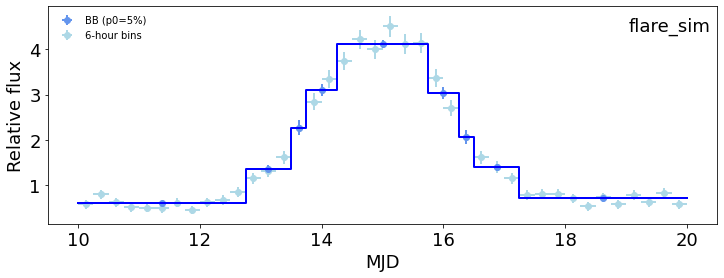

In [ ]:
bb = qday.bb_view();bb.plot();

This creates variable-sized cells corresponding to the Bayesian Block analysis, the fits for which are shown here:

In [ ]:
bb.fluxes

,t,tw,n,e,ts,flux,errors,limit
0,11.38,2.75,1398,64.8,1065.0,0.62,"(-0.029, 0.03)",0.67
1,13.12,0.75,567,64.8,1243.5,1.37,"(-0.075, 0.077)",1.50
2,13.62,0.25,263,64.8,965.2,2.27,"(-0.161, 0.168)",2.56
3,14.00,0.50,649,64.8,3333.4,3.09,"(-0.131, 0.135)",3.32
4,15.00,1.50,2496,64.8,15449.3,4.12,"(-0.087, 0.089)",4.26
5,16.00,0.50,637,64.8,3232.8,3.04,"(-0.13, 0.134)",3.27
6,16.38,0.25,233,64.8,883.7,2.07,"(-0.153, 0.16)",2.34
7,16.88,0.75,561,64.8,1309.6,1.40,"(-0.075, 0.077)",1.53
8,18.62,2.75,1516,64.8,1342.3,0.71,"(-0.031, 0.031)",0.77


### Getting help
This jupyterlab environment allows easy exploration of help for any class or function.
The two classes so far:

In [ ]:
Simulation = Simulation
Simulation?

Init signature:
Simulation(
    name,
    src_flux,
    tstart,
    tstop,
    bkg_rate=1e-06,
    efun=3000,
    wt_signif=0.1,
)
Docstring:      <no docstring>
Init docstring:
- src_flux : source flux, scalar or function of days, typically around 1e-7
- tstart, tstop :(days)
- bkg_rate : background flux, scalar or function of day, typicaly 1e-6 for 4-deg cone
- efun : scalar, function (of time in days) of the exposure/s. Typically 3000 cm^2 for fermi

- wt_signif : now the width of the PSF in (r/rmax)**2 coordinates
File:           /mnt/c/users/thbur/OneDrive/work/wtlike/wtlike/simulation.py
Type:           type
Subclasses:     


In [ ]:
WtLike?

Init signature: WtLike(*pars, **kwargs)
Docstring:     
Summary
---------
There are three layers of initialization, implemented in superclasses,
each with parameters. The classnames, associated parameters and data members set:

SourceData -- load photons and exposure
    parameters:
      - source : name, a PointSource object, or a Simulation object
      - config [Config()] : basic configuration
      - week_range [None] : range of weeks to load
      - key [''] : the cache key: '' means construct one with the source name, None to disable
      - clear [False] : if using cache, clear the contents first
    sets:
      - photons
      - exposure

CellData -- create cells
    parameters:
      - time_bins [Config().time_bins] : binning: start, stop, binsize
    sets:
      - cells

LightCurve -- likelihood analysis of the cells
    parameters:
      - e_min [10] -- threshold for exposure (cm^2 units)
      - n_min [2]  -- likelihood has trouble with this few
      - lc_key [None] -- pos

The three WtLike methods have (preliminary) help as well:

In [ ]:
WtLike.plot?

Signature: WtLike.plot(self, *pars, **kwargs)
Docstring:
Make a light curve plot
        Invokes flux_plot, after processing kwargs to intercept
        - log -- translate to `xscale='log'`
        - xlim [None] -- convert to (start, stop) interpreted relative to start, stop if < start.
        - show_flux [False]-- convert y scale to photon flux
        - UTC [False] -- convert x scale to UTC years
-
        Make a plot of flux vs. time. This is invoked by the `plot` function of `LightCurve`

    - cell_fits -- cell fits DataFrame
    - query ['']-- DataFrame query to select subset
    - ts_bar_min -- threshold for plotting as bar vs limit
    - tzero -- time offset, in MJD
    - source_name -- draw text in top left
    - flux_factor [1]

    - ax [None] -- a matplotlib.axes._subplots.AxesSubplot object returned from plt.subplots<br>
    if None, create one using subplots with fignum [1] and figsize [(12,4)]
    - fmt [''] -- marker symbol -- if not specifed, will use '.' if many bins

In [ ]:
WtLike.view?

Signature: WtLike.view(self, *pars, exp_min=None)
Docstring:
Return a "view", a copy of this instance with a perhaps a different set of cells

- pars -- start, stop, step  to define new binning. Or start, step, or just step
   start and stop are either MJD values, or offsets from the start or stop.
   step -- the cell size in days, or if zero, orbit-based binning

- exp_min [None] -- If specified, a different minimum exposure, in cm^2 Ms units to use for fitting
    from.
File:      /mnt/c/users/thbur/OneDrive/work/wtlike/wtlike/cell_data.py
Type:      function


## Using *Fermi* data.

The only change from the above code is that one substitues `PointSource` with the designation of a source, for `Simulation`. 

Also, the data files must be available, the config parameter `datapath` set to the relevant folder. 
Currently it is set by a line in `~/.config/wtlike/config.yaml`

This requires access to a packaged form of the photon data, a table allowing generation of weights, and the effective area table.
The source must have been analyzed with `gtlike` or `pointlike` to produce the weight table.

All are available in a 2-GB zip file.

In [ ]:
!cat ~/.config/wtlike/config.yaml
print('du -h ~/wtlike_data/')
!du -h ~/wtlike_data/*

verbose : 1
datapath : ~/wtlike_data
cachepath : ~/wtlike_cache

72K	/home/burnett/wtlike_data/aeff_files
2.7G	/home/burnett/wtlike_data/data_files
3.9M	/home/burnett/wtlike_data/weight_files


The photon and spacecraft data can be checked with `check_data`

In [ ]:
config= Config() # file paths must be valid for following.
if config.valid:
    check_data()

Weekly folder "/home/burnett/wtlike_data/data_files" contains 678 weeks.
	 Last week, # 687, has 3.469 days, ends at UTC 2021-08-01 11:20


The configuration must be valid, with path to data existing

In [ ]:
if config.valid:
    source = PointSource('3C 279'); source

In [ ]:
if config.valid:
    wtl = WtLike(source, exp_min=50)

SourceData:  3C 279: Restoring from cache with key "P88Y3243_data"
SourceData: Source 3C 279 with:
	 data:       180,481 photons from 2008-08-04 to 2021-07-30
	 exposure: 2,870,182 intervals,  average flux 2391 cm^2 for 85.7 Ms
	 rates:  source 4.68e-07/s, background 4.13e-07/s, S/N ratio 1.14e+00
CellData: Bin photon data into 677 1-week bins from 54683.0 to 59422.0


/home/burnett/miniconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


LightCurve: select 662 cells for fitting with e>50 & n>2


If the data for this source has not been accessed on this machine before, it must be extracted to a cache, a process that takes some 10 min. Otherwise it is a few seconds to retrieve the cache.

Generate the (default weekly) light curve:

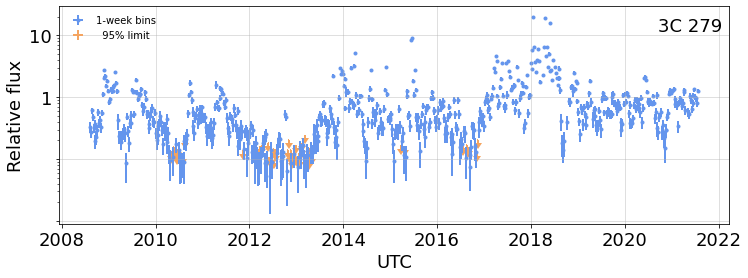

In [ ]:
if config.valid: wtl.plot(log=True, UTC=True);